In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.csv.gz'


In [3]:
%time sra_dump_df=pd.read_csv(sra_dump_pickle_dir)

<string>:2: DtypeWarning: Columns (5,6,25,26) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 41.6 s, sys: 3.56 s, total: 45.2 s
Wall time: 42.4 s


In [4]:
"""
ERP013950: some guy deposited tons of synthetic reads and annotate them as WGS
"""
blackListSrps=['ERP013950']

In [5]:
sra_dump_df.iloc[0]

Run                                                ERR1823524
Member_Name                                           default
Experiment                                         ERX1886028
Sample                                             ERS1545929
Study                                                       -
Spots                                                 1167564
Bases                                               426746666
Status                                                   live
BioSample                                       SAMEA80860918
ScientificName                          Staphylococcus_aureus
LibraryStrategy                                           WGS
LibraryLayout                                          PAIRED
proj_accession_Submission                           ERA809254
proj_accession_Status                                    live
proj_accession_Updated                   2018-04-06T11:36:57Z
proj_accession_Published                 2017-02-10T18:53:27Z
proj_acc

In [6]:
publicDf=sra_dump_df[(sra_dump_df.proj_accession_Visibility=='public')&(~sra_dump_df.Study.isin(blackListSrps))]

In [7]:
print ('# of human sequencing runs:',(publicDf.ScientificName=='Homo_sapiens').sum())

# of human sequencing runs: 604572


In [8]:
publicDf_human=publicDf[(publicDf.ScientificName=='Homo_sapiens')]
print ('# of human sequencing studies:',publicDf_human['Study'].nunique())

# of human sequencing studies: 10639


In [9]:
publicDf_human['LibraryStrategy']=publicDf_human['LibraryStrategy'].astype(str)

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
import matplotlib


Index(['RNA-Seq', 'WGS', 'AMPLICON', 'OTHER', 'WXS', 'ChIP-Seq'], dtype='object')


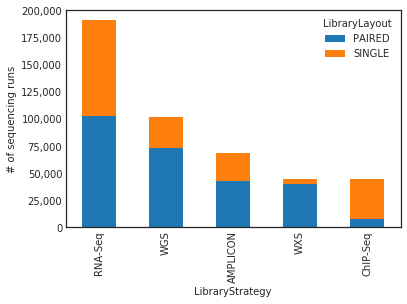

In [11]:
tmp_VC=publicDf_human['LibraryStrategy'].value_counts()
selectedVC=tmp_VC.index.astype(str)[tmp_VC.astype(float)>(4*(10.0**4))]
print (selectedVC)
selectedOrder=['RNA-Seq', 'WGS', 'AMPLICON', 'WXS', 'ChIP-Seq']
unstackDf=publicDf_human[publicDf_human.LibraryStrategy.isin(selectedOrder)
              ].groupby(['LibraryStrategy','LibraryLayout']).size().unstack()
ax=unstackDf.loc[selectedOrder].plot.bar(stacked=True)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('# of sequencing runs')
ax.figure.savefig('../Figures/LibraryLayout.pdf')
ax.figure.savefig('../Figures/LibraryLayout.png',dpi=300)

In [14]:
publicDf_human['Bases']=pd.to_numeric(publicDf_human['Bases'],errors='coerce')

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
print ('# of trillion bases:',publicDf_human['Bases'].sum()/(10.0**12))

# of trillion bases: 1836.921226719094


In [16]:
VC=publicDf.groupby(['ScientificName','LibraryStrategy']).size()

In [17]:
VC=VC.sort_values(ascending=False)

In [18]:
countBySrategy=VC.groupby('LibraryStrategy').sum()
ignore_strategy_list=(countBySrategy.index[countBySrategy<5000]
).tolist()
countBySpecie=VC.groupby('ScientificName').sum()
ignore_specie_list=countBySpecie.index[countBySpecie<20000].tolist()

In [19]:
#VC

In [20]:
m2=~VC.index.get_level_values('LibraryStrategy').isin(['CLONE','POOLCLONE','SELEX','OTHER','RAD-seq','RAD-Seq','Bisulfite-Seq']+ignore_strategy_list)
m3=~VC.index.get_level_values('ScientificName').isin([u'synthetic_construct']+ignore_specie_list)
subVC=VC[m2&m3].reorder_levels(['LibraryStrategy','ScientificName']).sort_index()#.unstack()

In [21]:
library_order=subVC.groupby('LibraryStrategy').sum().sort_values(ascending=False).index.astype(np.str)

scientific_order=subVC.groupby('ScientificName').sum().sort_values(ascending=False).index.astype(np.str)

In [22]:
yLabel='# of sequencing runs'

In [23]:
### stacked bar 

In [24]:
sortedS=subVC.sort_values(ascending=False).groupby(level='LibraryStrategy').head(15)

In [25]:
unstackDf=sortedS.unstack()

In [26]:
inPlotDf2=unstackDf.copy()

In [27]:
inPlotDf2.index=inPlotDf2.index.astype(np.str)
inPlotDf2.columns=inPlotDf2.columns.astype(np.str)

In [28]:
tmpS2=inPlotDf2.columns.to_series()
tmpS2[tmpS2.str.contains('metagenome')]='Metagenome'
plants=['Arabidopsis_thaliana','Oryza_sativa',u'Hordeum_vulgare_subsp._vulgare']
tmpS2[tmpS2.str.contains("|".join(plants))]='Plants'
prokaryotes=[u'Mycobacterium_tuberculosis',u'Plasmodium_falciparum',u'Saccharomyces_cerevisiae','Salmonella_enterica',
            u'Salmonella_enterica_subsp._enterica','Staphylococcus_aureus',u'Escherichia_coli',u'Streptococcus_pneumoniae']
tmpS2[tmpS2.str.contains("|".join(prokaryotes))]='Prokaryotes'
inPlotDf2.columns=tmpS2.values



In [29]:
tmpS3=inPlotDf2.index.to_series()
tmpS3[tmpS3.str.contains('rna-seq',case=False)]='RNA-seq'
tmpS3[tmpS3.str.contains('ATAC|DNase|chip',case=False)]='Chip / ATAC / DNase\n-seq'
tmpS3[tmpS3.str.contains('^WGA|WGS$',case=False)]='WGS'



inPlotDf2.index=tmpS3.values

In [30]:
inPlotDf3=inPlotDf2.groupby(level=0,axis=1).sum().groupby(level=0,axis=0).sum()

In [31]:
x_order3=inPlotDf3.sum(axis=1).sort_values(ascending=False).index
y_order3=inPlotDf3.sum(axis=0).sort_values(ascending=False).index

# data break down by organism and omic layer

In [32]:
VC2=(inPlotDf3.loc[x_order3,y_order3].iloc[:-3]/1000)
VC2.columns=VC2.columns.str.replace('_',' ')
VC2.columns=VC2.columns.str.replace('Drosophila melanogaster','Fruit fly')

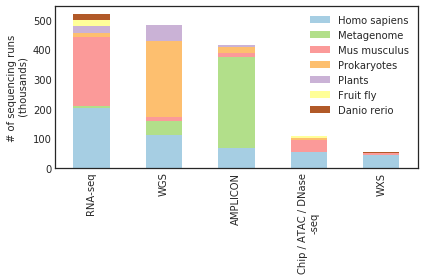

In [33]:
ax=VC2.plot.bar(stacked=True,colormap='Paired')
ax.set_ylabel('# of sequencing runs\n (thousands)')
ax.legend(bbox_to_anchor=(1.0,1))
ax.figure.tight_layout(w_pad=0.5)
ax.figure.savefig('./Figures/sra_data_availability.png',dpi=300,bbox_to_anchor='tight', pad_inches=0)

In [34]:
!echo $PWD/./Figures/sra_data_availability.png

/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/Analysis/./Figures/sra_data_availability.png


In [37]:
#!cp ./Figures/sra_data_availability.png ../Figures/sra_data_availability.png

# Data_growth

In [44]:
myDate='proj_accession_Received'
inPlotDf2=publicDf#sra_dump_df[sra_dump_df['proj_accession_Visibility']=='public']
#diffS=(inPlotDf2[myDate].astype(np.datetime64)-np.datetime64('2008','Y'))
a=inPlotDf2[myDate].astype(np.datetime64)
perYear=a.map(lambda s:s.year)


In [48]:
validYear=perYear[(perYear>=2008)&(perYear<2018)].astype(np.int)

In [49]:
countS=validYear.value_counts()
countS=countS.sort_index()

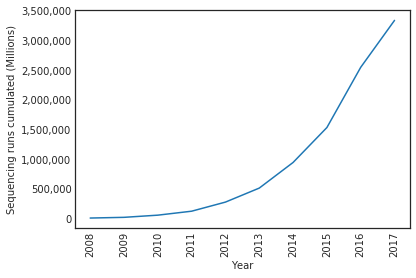

In [52]:
cumulativeS=countS.cumsum()
adjustedS=cumulativeS
ax=adjustedS.plot()
ax.set_ylabel('Sequencing runs cumulated (Millions)')
ax.set_xticks(cumulativeS.index)
ax.set_xticklabels(cumulativeS.index.astype(np.str), rotation='vertical')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.set_yscale('linear')
ax.set_xlabel('Year')

ax.figure.savefig('./Figures/sra_data_availability_over_time.png',dpi=300,bbox_inches='tight')
ax.figure.savefig('./Figures/sra_data_availability_over_time.pdf',bbox_inches='tight')

In [42]:
!cat ./../Pipelines/snp/param.py

#full_meta_dir="/cellar/users/btsui/Project/METAMAP/notebook/Parsing/sra_dump.csv"
full_meta_dir="/cellar/users/btsui/Data/SRA/DUMP/sra_dump.csv.gz"
unprocessed_meta_dir='/cellar/users/btsui/Data/SRA/all_seq/unprocessed_dump.snp.csv'
log_out_dir='/nrnb/users/btsui/Data/all_seq/log_snp/'
count_out_dir='/nrnb/users/btsui/Data/all_seq/snp/'
#SRR5422561
supporting_species=['Homo_sapiens']
supporting_library_strategy=['RNA-Seq','WGS','WXS','ChIP-Seq','AMPLICON']
supporting_layouts=['SINGLE','PAIRED']


In [43]:
print 'number of peta basess of data: ', sra_dump_df['Bases'].sum()/one_peta_bytes

SyntaxError: invalid syntax (<ipython-input-43-d6d96bfc2acc>, line 1)

### scratches

In [151]:
millionBases=sra_dump_df['Bases'].sum()/(10**6)

In [168]:
75*cost_per_mb

3.75

In [169]:
cost_per_mb=0.05
#1 cent per a million 
np.log10(millionBases*cost_per_mb)

8.8447085542647343

In [170]:
millionBases*cost_per_mb/(10**6)

699.3725045620188

In [176]:
sra_dump_df['Run']=sra_dump_df.index

In [179]:
indexedDf=sra_dump_df.set_index(['Study','Sample','Experiment','Run'])

In [183]:
#indexedDf.head()

In [184]:
#indexedDf[['ScientificName','LibraryStrategy','LibraryLayout']].iloc[100:]

In [109]:
VC

ScientificName                        LibraryStrategy
Mus_musculus                          RNA-Seq            229446
Homo_sapiens                          RNA-Seq            191243
                                      WGS                101606
soil_metagenome                       AMPLICON            90971
Hordeum_vulgare_subsp._vulgare        CLONE               83572
Homo_sapiens                          AMPLICON            76822
Salmonella_enterica                   WGS                 66794
human_gut_metagenome                  AMPLICON            64984
Homo_sapiens                          OTHER               58958
Escherichia_coli                      WGS                 49136
Homo_sapiens                          WXS                 44932
                                      ChIP-Seq            44292
Oryza_sativa                          WGS                 40623
Homo_sapiens                          POOLCLONE           37743
Mus_musculus                          ChIP-Seq    

In [8]:
## so as the meta data 
tmpDf3=publicDf[(publicDf.ScientificName=='Homo_sapiens')&(~publicDf.Study.isin(['ERP013950']))]

In [15]:
n_bases=tmpDf3['Bases'].sum()

In [21]:
nBytes=n_bases/2

In [23]:
nGb=(nBytes/10**9)*2

In [24]:
nGb

1834995.522362079